# MORDM optimization
## Imports


In [1]:
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import ema_logging, MultiprocessingEvaluator, Scenario, HypervolumeMetric
from ema_workbench.em_framework.optimization import (ArchiveLogger, EpsilonProgress, to_problem)
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import shutil
from datetime import datetime
import json

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

## Prepare model and settings

In [2]:
model, planning_steps = get_model_for_problem_formulation(2)

#The model requires a reference scenario to "kick-start"
reference_scenario = Scenario('reference', **{
    'discount rate-0': 1.5,
    'discount rate-1': 1.5,
    'discount rate-2': 1.5,
    'A.0_ID flood wave shape': 75,
    'A.1_Bmax': 240,
    'A.1_pfail': 0.25,
    'A.1_Brate': 10,
    'A.2_Bmax': 240,
    'A.2_pfail': 0.25,
    'A.2_Brate': 10,
    'A.3_Bmax': 240,
    'A.3_pfail': 0.25,
    'A.3_Brate': 10,
    'A.4_Bmax': 240,
    'A.4_pfail': 0.25,
    'A.4_Brate': 10,
    'A.5_Bmax': 240,
    'A.5_pfail': 0.25,
    'A.5_Brate': 10
})

nfe = 1000
epsilon = [0.5,0.5,0.5,0.01,0.01]

# Each epsilon value corresponds to a model outcome. The model outcomes are:
# expected damages, dike investment costs, rfr costs, evacuation cost, and casualties
# We select higher epsilon values to damages and costs, while we choose lower values for evacuation costs and casualties.


## Hypervolume and epsilon progress as convergence metrics

In [3]:
# Create the data folder if it doesn't exist, remove temp folder if it exists
Path("./MORDM_Data").mkdir(parents=True, exist_ok=True)
tmppath = Path('./MORDM_Data') / 'tmp'
if tmppath.exists() and tmppath.is_dir():
    shutil.rmtree(tmppath)

# Define the convergence metrics
convergence_metrics = [
    # Save data as archive, for hypervolume metric
    ArchiveLogger(
        "./MORDM_Data",
        [l.name for l in model.levers],
        [o.name for o in model.outcomes],
        base_filename="MORDM_HV_1.tar.gz",
    ),
    # Track epsilon progress
    EpsilonProgress(),
]

with MultiprocessingEvaluator(model) as evaluator:
    optimization_result, optimization_convergence = evaluator.optimize(nfe=nfe, searchover='levers', epsilons=epsilon,  convergence=convergence_metrics,reference=reference_scenario)

[MainProcess/INFO] pool started with 10 workers
1096it [00:19, 55.26it/s]                                                      
[MainProcess/INFO] optimization completed, found 51 solutions
[MainProcess/INFO] terminating pool


## Constrain results

Filtering the found solutions to those that are most important for the Delta Commission. Deaths should not exceed 0.001 for the entire territory, as well as adaptability measured in the form of a continuous set of measures that in the long run make sense (e.g., not following dike heightening with RfR to avoid losing the investment of the first timestep) and it is adaptive because it makes decisions in the different timesteps (CHECK SLIDES WITH THE METRO MAP OF ADAPTABILITY TO JUSTIFY)

In [4]:
# Select only those policies that result in an tolerable # of deaths
result_constrained = optimization_result[optimization_result['Expected Number of Deaths'] < 0.001]
result_constrained

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
1,0,0,0,0,0,0,1,1,1,1,...,3,7,3,1,5,0.000000e+00,3.776736e+08,711800000.0,0.000000,0.000000
5,1,1,0,0,0,1,0,1,0,1,...,1,3,7,0,1,1.805962e+06,3.658359e+08,660100000.0,0.000000,0.000821
7,0,1,0,0,0,0,0,1,1,0,...,2,2,6,2,7,0.000000e+00,5.492922e+08,146000000.0,0.000000,0.000000
10,1,1,0,0,0,0,1,0,0,1,...,2,9,2,3,4,6.971627e+06,4.022532e+08,442300000.0,182.012545,0.000298
11,1,0,0,0,0,1,1,0,1,0,...,4,6,5,7,0,1.801304e+06,4.588619e+08,363800000.0,0.000000,0.000817
17,1,1,0,0,0,0,0,0,0,1,...,1,4,2,2,7,8.326546e+06,3.982989e+08,532800000.0,172.136794,0.000567
20,0,0,0,0,0,0,1,1,1,1,...,4,5,3,2,7,0.000000e+00,4.855174e+08,334500000.0,0.000000,0.000000
23,0,0,0,0,0,0,1,1,0,1,...,2,1,7,0,1,8.197355e+06,4.623421e+08,182600000.0,170.246347,0.000549
25,1,0,0,0,0,0,1,0,1,1,...,7,5,3,5,1,0.000000e+00,4.138611e+08,388400000.0,0.000000,0.000000
40,1,0,0,0,0,0,1,1,1,0,...,7,5,7,4,4,0.000000e+00,4.908124e+08,176700000.0,0.000000,0.000000


In [5]:
def has_rfr_after_dh(series):
    for area in range(5):
        first_rfr_timestep = -1
        for timestep in range(3):
            if series[f"{area}_RfR {timestep}"] > 0:
                first_rfr_timestep = timestep
                break
        last_dike_timestep = 3
        for timestep in range(3):
            if series[f"A.{area + 1}_DikeIncrease {timestep}"] > 0:
                last_dike_timestep = timestep
        print(f"First RfR timestep: {first_rfr_timestep}; last DH timestep: {last_dike_timestep}")
        if first_rfr_timestep > last_dike_timestep:
            print("removing")
            return True

    print("keeping")
    return False

# Also remove policies that include RfR after dike heightening
result_constrained = result_constrained[result_constrained.apply(has_rfr_after_dh, axis="columns") == False]
result_constrained

First RfR timestep: -1; last DH timestep: 1
First RfR timestep: -1; last DH timestep: 0
First RfR timestep: 0; last DH timestep: 1
First RfR timestep: 0; last DH timestep: 2
First RfR timestep: 2; last DH timestep: 2
keeping
First RfR timestep: 0; last DH timestep: 2
First RfR timestep: 2; last DH timestep: 1
removing
First RfR timestep: 1; last DH timestep: 2
First RfR timestep: -1; last DH timestep: 1
First RfR timestep: 1; last DH timestep: 2
First RfR timestep: -1; last DH timestep: 2
First RfR timestep: -1; last DH timestep: 2
keeping
First RfR timestep: 0; last DH timestep: 2
First RfR timestep: -1; last DH timestep: 1
First RfR timestep: 0; last DH timestep: 2
First RfR timestep: 0; last DH timestep: 2
First RfR timestep: -1; last DH timestep: 2
keeping
First RfR timestep: 0; last DH timestep: 2
First RfR timestep: 2; last DH timestep: 2
First RfR timestep: 0; last DH timestep: 1
First RfR timestep: -1; last DH timestep: 2
First RfR timestep: -1; last DH timestep: 1
keeping
Firs

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
1,0,0,0,0,0,0,1,1,1,1,...,3,7,3,1,5,0.000000e+00,3.776736e+08,711800000.0,0.000000,0.000000
7,0,1,0,0,0,0,0,1,1,0,...,2,2,6,2,7,0.000000e+00,5.492922e+08,146000000.0,0.000000,0.000000
10,1,1,0,0,0,0,1,0,0,1,...,2,9,2,3,4,6.971627e+06,4.022532e+08,442300000.0,182.012545,0.000298
11,1,0,0,0,0,1,1,0,1,0,...,4,6,5,7,0,1.801304e+06,4.588619e+08,363800000.0,0.000000,0.000817
17,1,1,0,0,0,0,0,0,0,1,...,1,4,2,2,7,8.326546e+06,3.982989e+08,532800000.0,172.136794,0.000567
20,0,0,0,0,0,0,1,1,1,1,...,4,5,3,2,7,0.000000e+00,4.855174e+08,334500000.0,0.000000,0.000000
23,0,0,0,0,0,0,1,1,0,1,...,2,1,7,0,1,8.197355e+06,4.623421e+08,182600000.0,170.246347,0.000549
25,1,0,0,0,0,0,1,0,1,1,...,7,5,3,5,1,0.000000e+00,4.138611e+08,388400000.0,0.000000,0.000000
40,1,0,0,0,0,0,1,1,1,0,...,7,5,7,4,4,0.000000e+00,4.908124e+08,176700000.0,0.000000,0.000000
43,0,0,0,0,0,0,1,1,1,0,...,2,0,3,1,10,5.165665e+06,4.372618e+08,334500000.0,179.774593,0.000140


In [6]:
# Remove columns for outcomes from the dataframe, resulting in a df of polcies
policies = result_constrained.drop([o.name for o in model.outcomes], axis=1)
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
1,0,0,0,0,0,0,1,1,1,1,...,0,4,6,0,5,3,7,3,1,5
7,0,1,0,0,0,0,0,1,1,0,...,0,6,6,4,5,2,2,6,2,7
10,1,1,0,0,0,0,1,0,0,1,...,0,5,3,5,1,2,9,2,3,4
11,1,0,0,0,0,1,1,0,1,0,...,4,7,7,0,5,4,6,5,7,0
17,1,1,0,0,0,0,0,0,0,1,...,0,5,2,2,4,1,4,2,2,7
20,0,0,0,0,0,0,1,1,1,1,...,0,5,5,5,5,4,5,3,2,7
23,0,0,0,0,0,0,1,1,0,1,...,4,4,7,1,6,2,1,7,0,1
25,1,0,0,0,0,0,1,0,1,1,...,0,2,0,2,3,7,5,3,5,1
40,1,0,0,0,0,0,1,1,1,0,...,0,3,7,3,5,7,5,7,4,4
43,0,0,0,0,0,0,1,1,1,0,...,3,4,6,4,1,2,0,3,1,10


## Hypervolume metric

Here, there is an issue between the dike model and the EMA Workbench. The dike model defines value keys (levers, uncertainties, outcomes) that do not follow Python identifier standards, by including spaces or dots, or starting with digits.

We avoid this by replacing disallowed symbols with allowed (but otherwise unused) symbols, Ç and Ñ. We also add the letter "A" in front of keys starting with digits.

In [7]:
from copy import deepcopy

result_sanitized = optimization_result.copy()
model_sanitized = deepcopy(model)

# Here, we need to rename...
def sanitize_as_python_identifier(x):
    # Replace dots
    x = x.replace(".","Ç")
    # Replace spaces
    x = x.replace(" ","Ñ")
    # Add letter if starts with digit
    if x.startswith(("0","1","2","3","4","5")):
        x = "A" + x
    return x

# Reverse functions for if we need to get the original labels...
def desanitize_as_python_identifier(x):
    # Replace dots
    x = x.replace("Ç",".")
    # Replace spaces
    x = x.replace("Ñ"," ")
    # Add letter if starts with digit
    if x.startswith(("A0","A1","A2","A3","A4","A5")):
        x = x[1:]
    return x

result_sanitized.columns = [sanitize_as_python_identifier(x) for x in result_sanitized.columns]

for lev in model_sanitized.levers:
    lev.name = sanitize_as_python_identifier(lev.name)

for unc in model_sanitized.uncertainties:
    unc.name = sanitize_as_python_identifier(unc.name)

for out in model_sanitized.outcomes:
    out.name = sanitize_as_python_identifier(out.name)

In [8]:
# Load data from archive
archives = ArchiveLogger.load_archives("./MORDM_Data/MORDM_HV_1.tar.gz")

In [9]:

problem = to_problem(model_sanitized, searchover="levers")

hv = HypervolumeMetric(result_sanitized, problem)

print(f"Going over {len(archives.items())} archives...")
hypervolume = []

# As this iss a very slow process, we want to store the results at every step
hypervolume_folder = f"./Hypervolume_Data/{str(round(datetime.now().timestamp()))}"
Path(hypervolume_folder).mkdir(parents=True, exist_ok=True)


for i, (nfe, archive) in enumerate(archives.items()):
    print(datetime.now().strftime('%H:%M:%S') + " - Hypervolume calculate for archive #" + str(i))
    archive_sanitized = archive
    archive_sanitized.columns = [sanitize_as_python_identifier(x) for x in archive_sanitized.columns]
    the_result = (nfe, hv.calculate(archive))
    hypervolume.append(the_result)
    filename = hypervolume_folder + "/" + f"hv_data_count_{i}.json"
    with open(filename, "w") as fp:
        json.dump(hypervolume, fp)
    print(datetime.now().strftime('%H:%M:%S') + " - Dumped hypervolume data into file " + filename)
    # can be read with open("test", "r") - not implemented yet

hypervolume.sort(key=lambda x:x[0])
hypervolume = np.asarray(hypervolume)

Going over 3 archives...
10:07:27 - Hypervolume calculate for archive #0
10:07:27 - Dumped hypervolume data into file ./Hypervolume_Data/1686902848/hv_data_count_0.json
10:07:27 - Hypervolume calculate for archive #1
10:07:27 - Dumped hypervolume data into file ./Hypervolume_Data/1686902848/hv_data_count_1.json
10:07:27 - Hypervolume calculate for archive #2
10:07:28 - Dumped hypervolume data into file ./Hypervolume_Data/1686902848/hv_data_count_2.json


### Plot hypervolume and epsilon progress

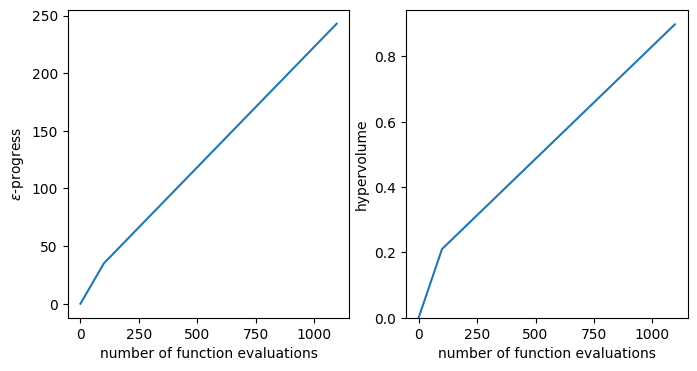

In [10]:
# Plot
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(optimization_convergence.nfe, optimization_convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(hypervolume[:, 0], hypervolume[:, 1])
ax2.set_ylim(ymin=0)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

### Plot the initial pool of solutions

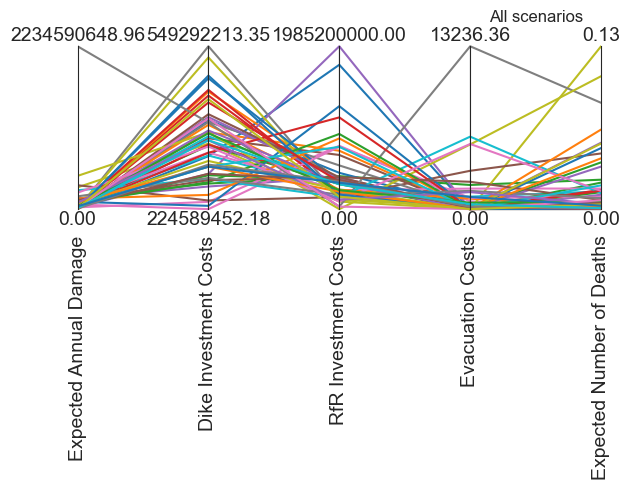

In [11]:
from ema_workbench.analysis import parcoords

data = optimization_result.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.title("All scenarios")
plt.show()

### Plot optimized solutions

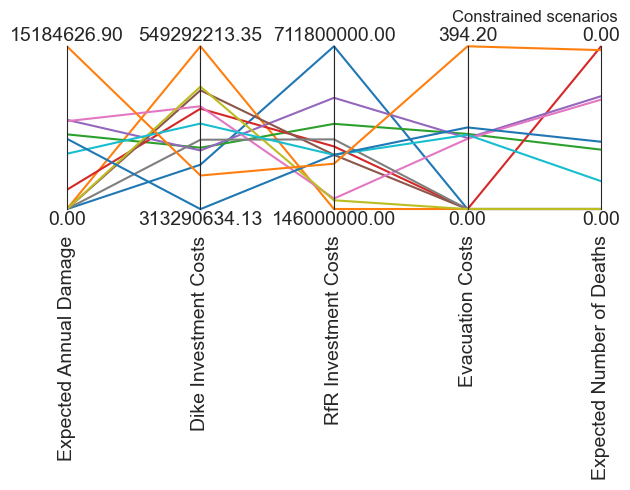

In [12]:
data = result_constrained.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.title("Constrained scenarios")
plt.show()